# Transfer Learning With Poutyne

In [1]:
%pip install --upgrade poutyne # to install lastest poutyne version, if it's not already
import os
import tarfile
import urllib.request

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils import model_zoo
from torch.utils.data import Subset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

from poutyne import set_seeds, Model, ModelCheckpoint, CSVLogger, Experiment

Also, we need to set Pythons's, NumPy's and PyTorch's seeds by using Poutyne function so that our training is (almost) reproducible.

In [2]:
set_seeds(42)

We download the dataset.

In [3]:
def download_and_extract_dataset(path):
    os.makedirs(path, exist_ok=True)
    tgz_filename = os.path.join(path, "images.tgz")

    print("Downloading dataset...")
    urllib.request.urlretrieve("https://graal.ift.ulaval.ca/public/CUB200.tgz", tgz_filename)
    print("Extracting archive...")
    archive = tarfile.open(tgz_filename)
    archive.extractall(path)

In [4]:
base_path = './datasets/CUB200'
extract_dest = os.path.join(base_path, 'images')
download_and_extract_dataset(base_path)

Extracting archive...


We create our dataset object.

In [5]:
norm_coefs = {}
norm_coefs['cub200'] = [(0.47421962, 0.4914721, 0.42382449), (0.22846779, 0.22387765, 0.26495799)]
norm_coefs['imagenet'] = [(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)]
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(*norm_coefs['cub200']),
    ]
)

# is_valid_file removes hidden files from the dataset.
dataset = ImageFolder(
    extract_dest,
    transform=transform,
    is_valid_file=lambda path: not os.path.split(path)[1].startswith('.'),
)

We do the split train/valid/test with a 60/20/20 split respectively. We do a *stratified* split with scikit-learn in order to get examples of every class in every split.

In [6]:
# We take 60% of the dataset for the training dataset
train_indices, valid_test_indices = train_test_split(
    np.arange(len(dataset)),
    train_size=0.6,
    stratify=dataset.targets,
    random_state=42,
)
# We take 20% for the validation dataset and 20% for the test dataset
# (i.e. 50% of the remaining 40%).
valid_indices, test_indices = train_test_split(
    valid_test_indices,
    train_size=0.5,
    stratify=np.asarray(dataset.targets)[valid_test_indices],
    random_state=42,
)

train_dataset = Subset(dataset, train_indices)
valid_dataset = Subset(dataset, valid_indices)
test_dataset = Subset(dataset, test_indices)

Now, let's set our training constants. We first have the CUDA device used for training if one is present. Secondly, we set the number of classes (i.e. one for each number). Finally, we set the batch size (i.e. the number of elements to see before updating the model), the learning rate for the optimizer, and the number of epochs (i.e. the number of times we see the full dataset).


In [7]:
# Training constants
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")

num_classes = 200
batch_size = 64
learning_rate = 0.1
n_epoch = 30

Creation of the PyTorch's dataloader to split our data into batches.

In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=8)

We load a pretrained `ResNet-18` networks and replace the head with the number of neurons equal to our number of classes.

In [9]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

We freeze the network except for its head.

In [10]:
def freeze_weights(resnet18):
    for name, param in resnet18.named_parameters():
        if not name.startswith('fc.'):
            param.requires_grad = False


freeze_weights(resnet18)

We define callbacks for saving last epoch, best epoch and logging the results.

In [11]:
# We are saving everything into ./saves/cub200.
save_base_dir = 'saves'
save_path = os.path.join(save_base_dir, 'cub200')
os.makedirs(save_path, exist_ok=True)

callbacks = [
    # Save the latest weights to be able to resume the optimization at the end for more epochs.
    ModelCheckpoint(os.path.join(save_path, 'last_epoch.ckpt')),
    # Save the weights in a new file when the current model is better than all previous models.
    ModelCheckpoint(
        os.path.join(save_path, 'best_epoch_{epoch}.ckpt'),
        monitor='val_acc',
        mode='max',
        save_best_only=True,
        restore_best=True,
        verbose=True,
    ),
    # Save the losses and accuracies for each epoch in a TSV.
    CSVLogger(os.path.join(save_path, 'log.tsv'), separator='\t'),
]

Finally, we start the training and output its final test loss, accuracy, and micro F1-score.

> Note that the F1-score is quite similar to the accuracy since the dataset is very balanced.

In [12]:
optimizer = optim.SGD(resnet18.fc.parameters(), lr=learning_rate, weight_decay=0.001)
loss_function = nn.CrossEntropyLoss()

model = Model(
    resnet18,
    optimizer,
    loss_function,
    batch_metrics=['accuracy'],
    epoch_metrics=['f1'],
    device=device,
)

model.fit_generator(
    train_loader,
    valid_loader,
    epochs=n_epoch,
    callbacks=callbacks,
)

test_loss, (test_acc, test_f1) = model.evaluate_generator(test_loader)

Epoch:  1/30 Train steps: 57 Val steps: 19 5.26s loss: 4.984878 acc: 4.614534 fscore_micro: 0.046145 val_loss: 4.329983 val_acc: 10.356255 val_fscore_micro: 0.103563
Epoch 1: val_acc improved from -inf to 10.35626, saving file to saves/cub200/best_epoch_1.ckpt
Epoch:  2/30 Train steps: 57 Val steps: 19 5.25s loss: 3.730639 acc: 23.984526 fscore_micro: 0.239845 val_loss: 3.651718 val_acc: 21.209611 val_fscore_micro: 0.212096
Epoch 2: val_acc improved from 10.35626 to 21.20961, saving file to saves/cub200/best_epoch_2.ckpt
Epoch:  3/30 Train steps: 57 Val steps: 19 5.28s loss: 2.916003 acc: 43.188726 fscore_micro: 0.431887 val_loss: 3.165393 val_acc: 30.571665 val_fscore_micro: 0.305717
Epoch 3: val_acc improved from 21.20961 to 30.57167, saving file to saves/cub200/best_epoch_3.ckpt
Epoch:  4/30 Train steps: 57 Val steps: 19 5.14s loss: 2.359695 acc: 55.457309 fscore_micro: 0.554573 val_loss: 2.882293 val_acc: 34.548467 val_fscore_micro: 0.345485
Epoch 4: val_acc improved from 30.57167 

In [13]:
logs = pd.read_csv(os.path.join(save_path, 'log.tsv'), sep='\t')
print(logs)

best_epoch_idx = logs['val_acc'].idxmax()
best_epoch = int(logs.loc[best_epoch_idx]['epoch'])
print("Best epoch: %d" % best_epoch)

    epoch      time   lr      loss        acc  fscore_micro  val_loss  \
0       1  5.261212  0.1  4.984878   4.614534      0.046145  4.329983   
1       2  5.254282  0.1  3.730639  23.984526      0.239845  3.651718   
2       3  5.275054  0.1  2.916003  43.188726      0.431887  3.165393   
3       4  5.139137  0.1  2.359695  55.457309      0.554573  2.882293   
4       5  5.009642  0.1  1.985980  64.548218      0.645482  2.743506   
5       6  5.019162  0.1  1.687166  71.566731      0.715667  2.572532   
6       7  4.915594  0.1  1.463140  76.291793      0.762918  2.474046   
7       8  5.151500  0.1  1.296519  79.856314      0.798563  2.370366   
8       9  4.922735  0.1  1.146529  82.508980      0.825090  2.339533   
9      10  5.330284  0.1  1.041320  86.156397      0.861564  2.260914   
10     11  5.067723  0.1  0.938370  87.759049      0.877590  2.215440   
11     12  5.465988  0.1  0.857947  89.195910      0.891959  2.191947   
12     13  5.788359  0.1  0.783668  91.710417      

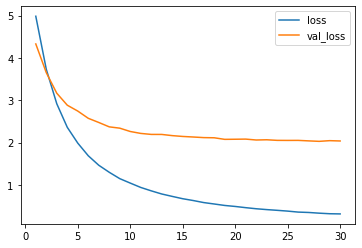

In [14]:
metrics = ['loss', 'val_loss']
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.show()

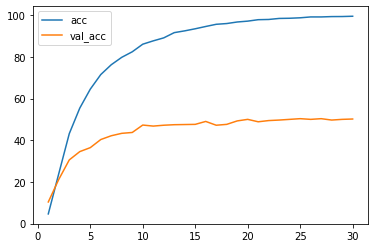

In [15]:
metrics = ['acc', 'val_acc']
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.show()

Since we have created checkpoints using callbacks, we can restore the best model from those checkpoints and test it.

In [16]:
resnet18 = models.resnet18(pretrained=False, num_classes=num_classes)

model = Model(
    resnet18,
    'sgd',
    'cross_entropy',
    batch_metrics=['accuracy'],
    epoch_metrics=['f1'],
    device=device,
)

model.load_weights(os.path.join(save_path, 'best_epoch_{epoch}.ckpt').format(epoch=best_epoch))

test_loss, (test_acc, test_f1) = model.evaluate_generator(test_loader)

Test steps: 19 1.59s test_loss: 2.002988 test_acc: 51.118476 test_fscore_micro: 0.511185           


We can also use the Experiment class to train our network. This class saves checkpoints and logs as above in a directory and allows to stop and resume optimization at will. See documentation for details.

In [17]:
def experiment_train(epochs):
    # Reload the pretrained network and freeze it except for its head.
    resnet18 = models.resnet18(pretrained=True)
    resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
    freeze_weights(resnet18)

    # Saves everything into ./saves/cub200_resnet18_experiment
    save_path = os.path.join(save_base_dir, 'cub200_resnet18_experiment')

    optimizer = optim.SGD(resnet18.fc.parameters(), lr=learning_rate, weight_decay=0.001)

    # Poutyne Experiment
    exp = Experiment(
        save_path,
        resnet18,
        device=device,
        optimizer=optimizer,
        task='classif',
    )

    # Train
    exp.train(train_loader, valid_loader, epochs=epochs)

    # Test
    exp.test(test_loader)

Let’s train for 5 epochs.

In [18]:
experiment_train(epochs=5)

Epoch: 1/5 Train steps: 57 Val steps: 19 5.18s loss: 4.972403 acc: 4.448743 fscore_micro: 0.044487 val_loss: 4.354537 val_acc: 11.350456 val_fscore_micro: 0.113505
Epoch 1: val_acc improved from -inf to 11.35046, saving file to saves/cub200_resnet18_experiment/checkpoint_epoch_1.ckpt
Epoch: 2/5 Train steps: 57 Val steps: 19 5.03s loss: 3.739010 acc: 23.984526 fscore_micro: 0.239845 val_loss: 3.638358 val_acc: 21.458161 val_fscore_micro: 0.214582
Epoch 2: val_acc improved from 11.35046 to 21.45816, saving file to saves/cub200_resnet18_experiment/checkpoint_epoch_2.ckpt
Epoch: 3/5 Train steps: 57 Val steps: 19 5.13s loss: 2.918689 acc: 41.503178 fscore_micro: 0.415032 val_loss: 3.234509 val_acc: 28.417564 val_fscore_micro: 0.284176
Epoch 3: val_acc improved from 21.45816 to 28.41756, saving file to saves/cub200_resnet18_experiment/checkpoint_epoch_3.ckpt
Epoch: 4/5 Train steps: 57 Val steps: 19 5.18s loss: 2.376595 acc: 55.153357 fscore_micro: 0.551534 val_loss: 2.913982 val_acc: 36.2054

Let’s train for 5 more epochs (10 epochs total).

In [19]:
# Retrain for 5 more epochs
experiment_train(epochs=10)

Loading weights from saves/cub200_resnet18_experiment/checkpoint.ckpt and starting at epoch 6.
Loading optimizer state from saves/cub200_resnet18_experiment/checkpoint.optim and starting at epoch 6.
Epoch:  6/10 Train steps: 57 Val steps: 19 5.16s loss: 1.668047 acc: 71.677259 fscore_micro: 0.716773 val_loss: 2.573154 val_acc: 41.425021 val_fscore_micro: 0.414250
Epoch 6: val_acc improved from 37.53107 to 41.42502, saving file to saves/cub200_resnet18_experiment/checkpoint_epoch_6.ckpt
Epoch:  7/10 Train steps: 57 Val steps: 19 5.01s loss: 1.463776 acc: 76.844432 fscore_micro: 0.768444 val_loss: 2.463882 val_acc: 43.744822 val_fscore_micro: 0.437448
Epoch 7: val_acc improved from 41.42502 to 43.74482, saving file to saves/cub200_resnet18_experiment/checkpoint_epoch_7.ckpt
Epoch:  8/10 Train steps: 57 Val steps: 19 5.41s loss: 1.282330 acc: 80.851064 fscore_micro: 0.808511 val_loss: 2.420289 val_acc: 44.159072 val_fscore_micro: 0.441591
Epoch 8: val_acc improved from 43.74482 to 44.1590